In [8]:
ditauPU1 = '/global/cfs/cdirs/m3443/data/TauStudies/v5/ditau_train_final1.root'
ditauPU2 = '/global/cfs/cdirs/m3443/data/TauStudies/v5/ditau_train_final2.root'
qcdPU = '/global/cfs/cdirs/m3443/data/TauStudies/v5/qcd_train_final.root'

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from root_gnn.src.datasets.tauid import TauIdentificationDataset

dataset = TauIdentificationDataset()

2022-06-27 13:58:28.113931: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /global/common/software/nersc/pm-2021q4/sw/darshan/3.3.1/lib:/opt/cray/pe/gcc/11.2.0/snos/lib64:/opt/cray/pe/papi/6.0.0.14/lib64:/opt/cray/libfabric/1.11.0.4.116/lib64
2022-06-27 13:58:28.114262: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Welcome to JupyROOT 6.26/04


In [3]:
import numpy as np
import pandas as pd
import itertools
from typing import Optional

from graph_nets import utils_tf


from root_gnn.src.datasets.base import DataSet

tree_name = "output"
def make_graph(event, debug=False):
    # globals
    def globals_scaling(outputs):
        new_outputs = [outputs[0]/100, outputs[1]/5, outputs[2]/np.pi]
        return outputs
    
    try:
        tau_info = [event.truthTauEt, event.truthTauEta, event.truthTauPhi]
        tau1_param = globals_scaling([param[0] for param in tau_info])
        tau2_param = globals_scaling([param[1] for param in tau_info])
        global_attr = tau1_param + tau2_param
        
    except IndexError:
        return [(None, None)]

    # nodes
    n_nodes = 0
    
    def get_track_info(idx):
        return [event.TrackPt[idx], event.TrackEta[idx], event.TrackPhi[idx]]

    def get_tower_info(idx):
        return [event.JetTowerEt[idx], event.JetTowerEta[idx], event.JetTowerPhi[idx]]

    
    nodes = []
    
    prev_num_track = 0
    prev_num_tower = 0
    
    node_indx = []
    inode = 0
    
    for indv_jet in range(event.nJets):
        
        # adding tracks associated with each jet
        for num_track in range(event.JetGhostTrackN[indv_jet]):
            track_idx = event.JetGhostTrackIdx[num_track+prev_num_track]
            nodes.append(get_track_info(track_idx))
            inode += 1
            
        prev_num_track += event.JetGhostTrackN[indv_jet]
            
        # add towers associated with each jet
        for num_tower in range(event.JetTowerN[indv_jet]):
            tower_idx = num_tower+prev_num_tower
            nodes.append(get_tower_info(tower_idx))
            inode += 1

        prev_num_tower += event.JetTowerN[indv_jet]
        
        node_indx.append(inode)
        
    nodes = np.tanh(np.array(nodes, dtype=np.float32))
    n_nodes = nodes.shape[0]
    
    if debug:
        #print(np.array(event.TrackPt).shape)
        assert node_indx[-1] == n_nodes, 'Nodes Error'
        print(n_nodes)
        print(nodes)

    # edges
    all_edges = []
    prev_node = 0
    for i in node_indx:
        all_edges += list(itertools.permutations(range(prev_node, i), 2))
        prev_node = i
    senders = np.array([x[0] for x in all_edges])
    receivers = np.array([x[1] for x in all_edges])
    n_edges = len(all_edges)
    edges = np.expand_dims(np.array([0.0]*n_edges, dtype=np.float32), axis=1)
    
    input_datadict = {
        "n_node": n_nodes,
        "n_edge": n_edges,
        "nodes": nodes,
        "edges": edges,
        "senders": senders,
        "receivers": receivers,
        "globals": np.array([0], dtype=np.float32)
    }
    target_datadict = {
        "n_node": n_nodes,
        "n_edge": n_edges,
        "nodes": nodes,
        "edges": edges,
        "senders": senders,
        "receivers": receivers,
        "globals": np.array(global_attr, dtype=np.float32)
    }
    input_graph = utils_tf.data_dicts_to_graphs_tuple([input_datadict])
    target_graph = utils_tf.data_dicts_to_graphs_tuple([target_datadict])
    
    return [(input_graph, target_graph)]

def read(filename):
    import ROOT
    chain = ROOT.TChain(tree_name, tree_name) # pylint: disable=maybe-no-member
    chain.Add(filename)
    n_entries = chain.GetEntries()
    print("Total {:,} Events".format(n_entries))

    for ientry in range(n_entries):
        chain.GetEntry(ientry)
        yield chain


class DiTauMassDataset(DataSet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.read = read
        self.make_graph = make_graph

    def _num_evts(self, filename):
        import ROOT
        chain = ROOT.TChain(tree_name, tree_name) # pylint: disable=maybe-no-member
        chain.Add(filename)
        n_entries = chain.GetEntries()
        return n_entries
    '''
    def subprocess(self, ijob, graphs, num_workers, n_file, n_evts_per_record, filename, outname, overwrite, debug):
        
        now = time.time()
        outname = "{}_{}.tfrec".format(outname, ijob)
        if os.path.exists(outname) and not overwrite:
            print(outname,"is there. skip...")
            return 0, n_evts_per_record

        start_entry = ijob * n_evts_per_record
        all_graphs = graphs[start_entry:start_entry+n_evts_per_record]
        
        isaved = len(all_graphs)
        ex_input, ex_target = all_graphs[0]
        input_dtype, input_shape = graph.dtype_shape_from_graphs_tuple(
            ex_input, with_padding=self.with_padding)
        target_dtype, target_shape = graph.dtype_shape_from_graphs_tuple(
            ex_target, with_padding=self.with_padding)
        def generator():
            for G in all_graphs:
                yield (G[0], G[1])

        dataset = tf.data.Dataset.from_generator(
            generator,
            output_types=(input_dtype, target_dtype),
            output_shapes=(input_shape, target_shape),
            args=None)

        writer = tf.io.TFRecordWriter(outname)
        for data in dataset:
            example = graph.serialize_graph(*data)
            writer.write(example)
        writer.close()
        cur = time.time()
        del_time = (cur - now) / 60
        speed = round(del_time / num_workers, 2)
        print(f"Jobs Remaining: {n_file-ijob}; Estimated Time: {speed * (n_file-ijob)}mins")

        

    def process(self, filename, outname, n_evts_per_record, debug, max_evts, num_workers=1, overwrite=False, **kwargs):
        
        now = time.time()

        all_evts = self._num_evts(filename)
        all_evts = max_evts if max_evts > 0 and all_evts > max_evts else all_evts

        all_graphs = []
        file = read(filename)
        failed = 0
        for i in range(all_evts):
            g = make_graph(next(file))
            if g[0][0] != None:
                all_graphs += g
            else:
                failed += 1
                
        print(f"Number of read graph: {all_evts}; Number of successful graph: {all_evts-failed}; \nNumber of failed graph: {failed}; Proportion: {failed/all_evts}")
                
        n_files = (all_evts-failed) // n_evts_per_record
        if (all_evts-failed)%n_evts_per_record > 0:
            n_files += 1

        print("Total {:,} events are requested to be written to {:,} files with {:,} workers".format(all_evts, n_files, num_workers))
        out_dir = os.path.abspath(os.path.dirname(outname))
        os.makedirs(out_dir, exist_ok=True)
        
        if num_workers < 2:
            ifailed, isaved=0, 0
            for ijob in range(n_files):
                self.subprocess(ijob, all_graphs, num_workers, n_files, n_evts_per_record, filename, outname, overwrite, debug)

        else:
            with Pool(num_workers) as p:
                process_fnc = partial(self.subprocess,
                        graphs=all_graphs,
                        num_workers=num_workers,
                        n_file=n_files,
                        n_evts_per_record=n_evts_per_record,
                        filename=filename,
                        outname=outname,
                        overwrite=overwrite,
                        debug=debug)
                p.map(process_fnc, list(range(n_files)))

            
        read_time = time.time() - now
        print("{} added {:,} events, in {:.1f} mins".format(self.__class__.__name__,
            isaved, read_time/60.))
        '''

# Utility Functions

In [10]:
def get_num_track_tower(event):
    """
    Get the number of tracks and towers per jet in the event
    OUTPUT: a tuple (ntrack_per_jet, ntower_per_jet), where each element in it is an array of the number of tracks or towers, 
    with length = number of jets in the event
    """

    ntrack_per_jet = [event.JetGhostTrackN[indv_jet] for indv_jet in range(event.nJets)]
    ntower_per_jet = [event.JetTowerN[indv_jet] for indv_jet in range(event.nJets)]

    return ntrack_per_jet, ntower_per_jet

# Plots

In [11]:
def get_plotting_param(arr):
    weights = []
    for i in arr:
        weights.append(np.ones_like(i) / len(i))
    rg = [[int(min(i)-0.5), int(max(i)+0.5)] for i in arr]
    bin_wid = 1
    rg_f = min([i[0] for i in rg]), max([i[1] for i in rg])
    num_bins = int((rg_f[1]-rg_f[0])/bin_wid)
    return weights, rg_f, num_bins

In [13]:
import math
def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    if dphi > np.pi:
        dphi -= 2*np.pi
    if dphi < -np.pi:
        dphi += 2*np.pi
    return dphi

def ori_get_info(chain):
    signals = []
    d_all, z_all = [], []
    hlv_all = []
    track_idx = 0
    for ijet in range(chain.nJets):
        # Filtering out reco jets
        d, z = [], []
        n_core_tracks = 0
        if chain.JetPt[ijet] < 30 or abs(chain.JetEta[ijet]) >= 3:
            signals.append(-1)
            d_all.append(d)
            z_all.append(z)
            hlv_all.append([])
            continue
        # Match jet to truth jet that minimizes angular distance
        split_point = 0
        nodes = []
        tower_nodes = []
        track_nodes = []
        min_index = 0
        if chain.nTruthJets > 0:
            min_dR = math.sqrt(calc_dphi(chain.JetPhi[ijet],chain.TruthJetPhi[0])**2 + (chain.JetEta[ijet]-chain.TruthJetEta[0])**2)
        for itruth in range(chain.nTruthJets):
            dR = math.sqrt(calc_dphi(chain.JetPhi[ijet],chain.TruthJetPhi[itruth])**2 + (chain.JetEta[ijet]-chain.TruthJetEta[itruth])**2)
            if dR < min_dR:
                min_dR = dR
                min_index = itruth
        if chain.nTruthJets > 0 and min_dR < 0.4:
            isTau = chain.TruthJetIsTautagged[min_index]
        else:
            isTau = 0
        
        
        for itrack in range(chain.JetGhostTrackN[ijet]):
            ghost_track_idx = chain.JetGhostTrackIdx[track_idx]
            theta = 2*math.atan(-math.exp(chain.TrackEta[ghost_track_idx]))
            deta = chain.JetEta[ijet]-chain.TrackEta[ghost_track_idx]
            dphi = calc_dphi(chain.JetPhi[ijet],chain.TrackPhi[ghost_track_idx])
            dR = math.sqrt(dphi**2 + deta**2)
            if dR <= 0.2:
                n_core_tracks+=1
                
            z0 = math.log10(10e-3+math.fabs(chain.TrackZ0[ghost_track_idx]*math.sin(theta)))
            d0 = math.log10(10e-3+math.fabs(chain.TrackD0[ghost_track_idx]))
            d.append(d0)
            z.append(z0)
            track_idx+=1
        
        if isTau:
            if n_core_tracks == 0:
                signals.append(-2)
            else:
                signals.append(n_core_tracks)
        else:
            signals.append(isTau)
        d_all.append(d)
        z_all.append(z)
        hlv_all.append([getattr(chain, hlv) for hlv in highVarNames])
        
    return signals, d_all, z_all, hlv_all

In [14]:
import math
def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    if dphi > np.pi:
        dphi -= 2*np.pi
    if dphi < -np.pi:
        dphi += 2*np.pi
    return dphi

def get_info(chain):
    signals = []
    d_all, z_all = [], []
    hlv_all = []
    track_idx = 0
    for ijet in range(chain.nJets):
        # Filtering out reco jets
        d, z = [], []
        n_core_tracks = 0
        if chain.JetPt[ijet] < 30 or abs(chain.JetEta[ijet]) >= 3:
            signals.append(-1)
            #d_all.append(d)
            #z_all.append(z)
            #hlv_all.append([])
            continue
        # Match jet to truth jet that minimizes angular distance
        split_point = 0
        nodes = []
        tower_nodes = []
        track_nodes = []
        min_index = 0
        if chain.nTruthJets > 0:
            min_dR = math.sqrt(calc_dphi(chain.JetPhi[ijet],chain.TruthJetPhi[0])**2 + (chain.JetEta[ijet]-chain.TruthJetEta[0])**2)
        for itruth in range(chain.nTruthJets):
            dR = math.sqrt(calc_dphi(chain.JetPhi[ijet],chain.TruthJetPhi[itruth])**2 + (chain.JetEta[ijet]-chain.TruthJetEta[itruth])**2)
            if dR < min_dR:
                min_dR = dR
                min_index = itruth
        if chain.nTruthJets > 0 and min_dR < 0.4:
            isTau = chain.TruthJetIsTautagged[min_index]
        else:
            isTau = 0
        
        
        for itrack in range(chain.JetGhostTrackN[ijet]):
            ghost_track_idx = chain.JetGhostTrackIdx[track_idx]
            theta = 2*math.atan(-math.exp(chain.TrackEta[ghost_track_idx]))
            deta = chain.JetEta[ijet]-chain.TrackEta[ghost_track_idx]
            dphi = calc_dphi(chain.JetPhi[ijet],chain.TrackPhi[ghost_track_idx])
            dR = math.sqrt(dphi**2 + deta**2)
            if dR <= 0.2:
                n_core_tracks+=1
                
            #z0 = math.log10(10e-3+math.fabs(chain.TrackZ0[ghost_track_idx]*math.sin(theta)))
            #d0 = math.log10(10e-3+math.fabs(chain.TrackD0[ghost_track_idx]))
            #d.append(d0)
            #z.append(z0)
            track_idx+=1
        
        if isTau:
            if n_core_tracks == 0:
                signals.append(-2)
            else:
                signals.append(n_core_tracks)
        else:
            signals.append(isTau)
        #d_all.append(d)
        #z_all.append(z)
        #hlv_all.append([getattr(chain, hlv) for hlv in highVarNames])
        
    return signals

In [ ]:
import tqdm
num_track = []
num_tower = []

isTau = []
ditau_nJets = []
qcd_nJets = []

d0 = []
z0 = []

ditau_file1 = dataset.read(ditauPU1, 0, float('inf'))
ditau_file2 = dataset.read(ditauPU2, 0, float('inf'))
qcd_file = dataset.read(qcdPU, 0, float('inf'))

for _ in tqdm.trange(dataset._num_evts(ditauPU1), desc="ditau1"):
    f = next(ditau_file1)
    num_track += get_num_track_tower(f)[0]
    num_tower += get_num_track_tower(f)[1]
    #ditau_nJets += [f.nJets]
    istau = get_info(f)
    isTau += istau

    
for _ in tqdm.trange(dataset._num_evts(ditauPU2), desc="ditau2"):
    f = next(ditau_file2)
    num_track += get_num_track_tower(f)[0]
    num_tower += get_num_track_tower(f)[1]
    #ditau_nJets += [f.nJets]
    istau += get_info(f)
    #isTau += istau
    #d0 += d
    #z0 += z

for _ in tqdm.trange(dataset._num_evts(qcdPU), desc="qcd"):
    f = next(qcd_file)
    num_track += get_num_track_tower(f)[0]
    num_tower += get_num_track_tower(f)[1]
    qcd_nJets += [f.nJets]
    istau = get_info(f)
    isTau += istau

ditau2:  49%|████▊     | 428219/879396 [40:21<39:26, 190.66it/s]  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
data_file = '/pscratch/sd/a/andrish/tauid_vars.csv'
df = pd.read_csv(data_file, sep=',', engine='python', nrows=10)

ParserError: Expected 291 fields in line 4, saw 449

In [6]:
df

,"IsSignal,num_tracks,num_towers,d0,z0,JetCentralEFrac,JetLeadingTrackFracP,JetTrackR,JetMaxDRInCore,JetNumISOTracks,JetLeadingTrackD0,JetTrackMass"
0,"0,116,54,|[-1.9999999999971627, -2.0, 1.582965..."
1,"0,74,46,|[-2.0, -2.0, -1.9999999999732314, -2...."
2,"0,195,60,|[-2.0, -2.0, -2.0, -2.0, -2.0, -2.0,..."
3,"0,177,67,|[-2.0, -2.0, -2.0, -2.0, -2.0, -2.0,..."
4,"0,168,60,|[-2.0, -2.0, -2.0, -2.0, -1.99999999..."
5,"0,65,44,|[-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, ..."
6,"0,152,62,|[-2.0, -2.0, -2.0, -2.0, -1.99999999..."
7,"0,74,24,|[-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, ..."
8,"0,116,54,|[-2.0, -2.0, -2.0, -2.0, -2.0, -2.0,..."
9,"0,74,46,|[-2.0, -2.0, -1.9999999999871443, -2...."


In [8]:
total_jets = len(num_track)
assert total_jets == len(num_tower) == len(isTau)
n_tau_tracks = [num_track[i] for i in range(total_jets) if isTau[i] > 0]
n_qcd_tracks = [num_track[i] for i in range(total_jets) if isTau[i] == 0]
n_tau_towers = [num_tower[i] for i in range(total_jets) if isTau[i] > 0]
n_qcd_towers = [num_tower[i] for i in range(total_jets) if isTau[i] == 0]
filtered_out = sum([1 for i in isTau if i == -1])
print(f'Total {total_jets} jets')
print(f'Filtered Out: {filtered_out} jets, {filtered_out/total_jets*100:.2f}%')
print(f'Tau Jets: {len(n_tau_tracks)} jets, {len(n_tau_tracks)/total_jets*100:.2f}%')
print(f'Non-tau Jets: {len(n_qcd_tracks)} jets, {len(n_qcd_tracks)/total_jets*100:.2f}%')

Total 8361436 jets
Filtered Out: 2468635 jets, 29.52%
Tau Jets: 273251 jets, 3.27%
Non-tau Jets: 5619550 jets, 67.21%


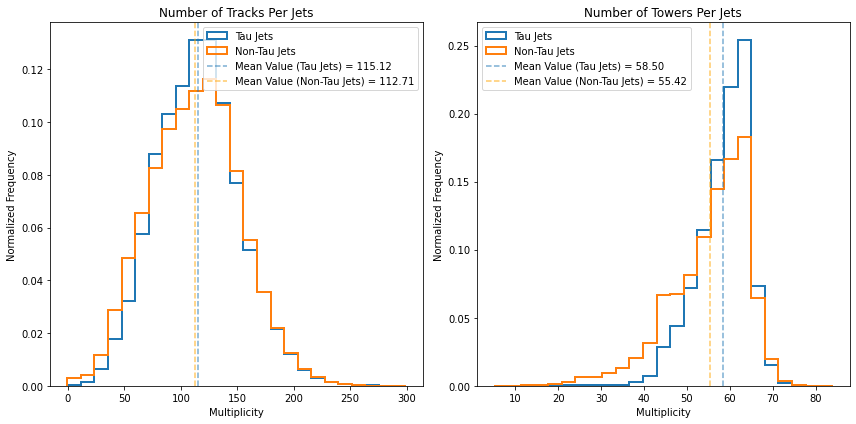

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
weights, rg, num_bins = get_plotting_param([n_tau_tracks, n_qcd_tracks])
ax[0].hist(n_tau_tracks, range=(-0.5, 299.5), bins=25, weights=weights[0], align='mid', label='Tau Jets', histtype='step', lw=2)
ax[0].hist(n_qcd_tracks, range=(-0.5, 299.5), bins=25, weights=weights[1], align='mid', label='Non-Tau Jets', histtype='step', lw=2)

n_tau_tracks_avg = np.mean(n_tau_tracks)
n_qcd_tracks_avg = np.mean(n_qcd_tracks)
ax[0].axvline(n_tau_tracks_avg, linestyle='dashed', alpha=0.6, label=f'Mean Value (Tau Jets) = {n_tau_tracks_avg:.2f}')
ax[0].axvline(n_qcd_tracks_avg, linestyle='dashed', alpha=0.6, color='orange', label=f'Mean Value (Non-Tau Jets) = {n_qcd_tracks_avg:.2f}')

ax[0].set_title('Number of Tracks Per Jet')
ax[0].set_ylabel('Normalized Frequency')
ax[0].set_xlabel('Multiplicity')
ax[0].legend()

weights, rg, num_bins = get_plotting_param([n_tau_towers, n_qcd_towers])
ax[1].hist(n_tau_towers, range=rg, bins=25, weights=weights[0], align='mid', label='Tau Jets', histtype='step', lw=2)
ax[1].hist(n_qcd_towers, range=rg, bins=25, weights=weights[1], align='mid', label='Non-Tau Jets', histtype='step', lw=2)

n_tau_towers_avg = np.mean(n_tau_towers)
n_qcd_towers_avg = np.mean(n_qcd_towers)
ax[1].axvline(n_tau_towers_avg, linestyle='dashed', alpha=0.6, label=f'Mean Value (Tau Jets) = {n_tau_towers_avg:.2f}')
ax[1].axvline(n_qcd_towers_avg, linestyle='dashed', alpha=0.6, color='orange', label=f'Mean Value (Non-Tau Jets) = {n_qcd_towers_avg:.2f}')

ax[1].set_title('Number of Towers Per Jet')
ax[1].set_ylabel('Normalized Frequency')
ax[1].set_xlabel('Multiplicity')
ax[1].legend()

plt.tight_layout()
plt.show()
plt.savefig('Number_of_tracks_towers.pdf')

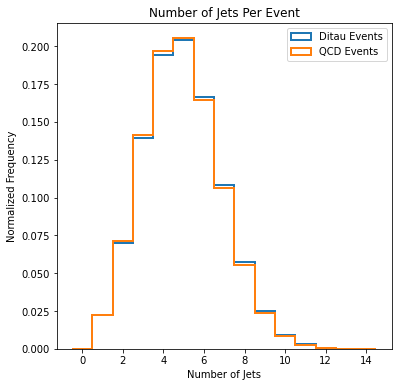

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
weights = np.ones_like(ditau_nJets) / len(ditau_nJets)
ax.hist(ditau_nJets, align='mid', bins=15, range=(-0.5, 14.5), weights=weights, histtype='step', lw=2, label=f'Ditau Events')
weights = np.ones_like(qcd_nJets) / len(qcd_nJets)
ax.hist(qcd_nJets, align='mid', bins=15, range=(-0.5, 14.5), weights=weights, histtype='step', lw=2, label=f'QCD Events')
ax.set_title(f'Number of Jets Per Event')
ax.set_ylabel('Normalized Frequency')
ax.set_xlabel("Multiplicity")
ax.legend()
plt.show()
plt.savefig('Number_of_jets.pdf')

In [19]:
tau_d0 = []
non_tau_d0 = []
tau_z0 = []
non_tau_z0 = []

d0 = np.concatenate(d0, axis=None)
z0 = np.concatenate(z0, axis=None)

In [23]:
index = 0
for i in tqdm.trange(total_jets):
    n_track = num_track[i]
    if isTau[i] == 0:
        non_tau_d0.extend(d0[index:index+n_track])
        non_tau_z0.extend(z0[index:index+n_track])
    elif isTau[i] > 0:
        tau_d0.extend(d0[index:index+n_track])
        tau_z0.extend(z0[index:index+n_track])
    index += n_track

100%|██████████| 8361436/8361436 [02:12<00:00, 63154.40it/s] 


In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
weights, rg, num_bins = get_plotting_param([tau_d0, non_tau_d0])
ax[0].hist(tau_d0, range=rg, bins=num_bins, weights=weights[0], align='mid', label='Tau Jets', histtype='step', lw=2)
ax[0].hist(non_tau_d0, range=rg, bins=num_bins, weights=weights[1], align='mid', label='Non-Tau Jets', histtype='step', lw=2)

ax[0].set_title(r'Transverse Impact Parameter $d_0$')
ax[0].set_ylabel('Normalized Frequency')
ax[0].set_xlabel(r'Scaled $d_0$')
ax[0].legend()

weights, rg, num_bins = get_plotting_param([tau_z0, non_tau_z0])
ax[1].hist(tau_z0, range=rg, bins=num_bins, weights=weights[0], align='mid', label='Tau Jets', histtype='step', lw=2)
ax[1].hist(non_tau_z0, range=rg, bins=num_bins, weights=weights[1], align='mid', label='Non-Tau Jets', histtype='step', lw=2)

ax[1].set_title(r'Longitudinal Impact Parameter $z_0$')
ax[1].set_ylabel('Normalized Frequency')
ax[1].set_xlabel(r'Scaled $z_0$')
ax[1].legend()

plt.tight_layout()
plt.show()
plt.savefig('d0_z0.pdf')